In [1]:
import requests
import calendar
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
station = 'IEDINBUR6' # Edinburgh
data_raw = pd.read_csv('weather_station_hourly_data/{}_weather.csv'.format(station))

In [3]:
data_raw.head()

,Unnamed: 0,Time,TemperatureC,DewpointC,PressurehPa,WindDirection,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,Conditions,Clouds,dailyrainMM,SolarRadiationWatts/m^2,SoftwareType,DateUTC,station
0,0,2015-01-01 00:00:00,10.3,4.5,1001.9,SW,236,9.0,11.9,67,0.0,NaN,NaN,0.0,0.0,HP1001 V1.1.3,2015-01-01 00:00:00,IEDINBUR6
1,1,2015-01-01 00:06:00,10.2,4.4,1001.9,SW,226,6.9,7.9,67,0.0,NaN,NaN,0.0,0.0,HP1001 V1.1.3,2015-01-01 00:06:00,IEDINBUR6
2,2,2015-01-01 00:11:00,10.2,4.4,1001.9,SSW,202,7.2,15.8,67,0.0,NaN,NaN,0.0,0.0,HP1001 V1.1.3,2015-01-01 00:11:00,IEDINBUR6
3,3,2015-01-01 00:16:00,10.2,4.4,1001.9,SSW,202,7.9,11.9,67,0.0,NaN,NaN,0.0,0.0,HP1001 V1.1.3,2015-01-01 00:16:00,IEDINBUR6
4,4,2015-01-01 00:21:00,10.2,4.6,1002.3,South,174,4.3,7.9,68,0.0,NaN,NaN,0.0,0.0,HP1001 V1.1.3,2015-01-01 00:21:00,IEDINBUR6


In [4]:
# Give the variables some friendlier names and convert types as necessary.
data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)
data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
data_raw['wind'] = data_raw['WindSpeedKMH']

In [5]:
# Extract out only the data we need.
data = data_raw.loc[:, ['date', 'station', 'temp', 'rain', 'total_rain', 'humidity', 'wind']]
data = data[(data['date'] >= datetime(2015,1,1)) & (data['date'] <= datetime(2015,12,31))]
data.head()

,date,station,temp,rain,total_rain,humidity,wind
0,2015-01-01 00:00:00,IEDINBUR6,10.3,0.0,0.0,67.0,9.0
1,2015-01-01 00:06:00,IEDINBUR6,10.2,0.0,0.0,67.0,6.9
2,2015-01-01 00:11:00,IEDINBUR6,10.2,0.0,0.0,67.0,7.2
3,2015-01-01 00:16:00,IEDINBUR6,10.2,0.0,0.0,67.0,7.9
4,2015-01-01 00:21:00,IEDINBUR6,10.2,0.0,0.0,68.0,4.3


In [6]:
data[data['rain'] < -500]

,date,station,temp,rain,total_rain,humidity,wind
55988,2015-07-17 15:13:00,IEDINBUR6,-573.3,-2539.7,-2539.7,-9999.0,-1608.8


In [7]:
# There's an issue with some stations that record rainfall ~-2500 where data is missing.
if (data['rain'] < -500).sum() > 10:
    print("There's more than 10 messed up days for {}".format(station))
    
# remove the bad samples
data = data[data['rain'] > -500]

In [8]:
# Assign the "day" to every date entry
data['day'] = data['date'].apply(lambda x: x.date())

# Get the time, day, and hour of each timestamp in the dataset
data['time_of_day'] = data['date'].apply(lambda x: x.time())
data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)

# Mark the month for each entry so we can look at monthly patterns
data['month'] = data['date'].apply(lambda x: x.month)

In [9]:
# Is each time stamp on a working day (Mon-Fri)
data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)

In [10]:
# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))

In [11]:
# If there's any rain at all, mark that!
data['raining'] = data['rain'] > 0.0

# You get wet cycling if its a working day, and its raining at the travel times!
data['get_wet_cycling'] = (data['working_day']) & ((data['morning'] & data['rain']) |
                                                   (data['evening'] & data['rain']))

In [12]:
# Looking at the working days only and create a daily data set of working days:
wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
wet_cycling = pd.DataFrame(wet_cycling).reset_index()
wet_cycling.head()

,day,get_wet_cycling
0,2015-01-01,True
1,2015-01-02,False
2,2015-01-05,False
3,2015-01-06,True
4,2015-01-07,True


In [13]:
# Group by month for display - monthly data set for plots.
wet_cycling['month'] = wet_cycling['day'].apply(lambda x: x.month)
monthly = wet_cycling.groupby('month')['get_wet_cycling'].value_counts().rename(columns={"get_wet_cycling":"Rainy"}, inplace=True)
monthly = monthly.reset_index()
monthly.rename(columns={"get_wet_cycling":"Rainy", 0:"Days"}, inplace=True)
monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)    
monthly['month_name'] = monthly['month'].apply(lambda x: calendar.month_abbr[x])
monthly.head()

,month,Rainy,Days,month_name
0,1,Dry,16,Jan
1,1,Wet,6,Jan
2,2,Dry,19,Feb
3,2,Wet,1,Feb
4,3,Dry,18,Mar


In [14]:
# Get aggregate stats for each day in the dataset on rain in general - for heatmaps.
rainy_days = data.groupby(['day']).agg({
        "rain": [("rain", lambda x: (x > 0.0).any()), ("rain_amount", "sum")],
        "total_rain": [("total_rain", "max")],
        "get_wet_cycling": [("get_wet_cycling", "any")]
        })

In [15]:
# clean up the aggregated data to a more easily analysed set:
rainy_days.reset_index(inplace=True) # remove the 'day' as the index
rainy_days.rename(columns={"":"date"}, inplace=True) # The old index column didn't have a name - add "date" as name
rainy_days.columns = rainy_days.columns.droplevel(level=0) # The aggregation left us with a multi-index
                                                           # Remove the top level of this index.
rainy_days['rain'] = rainy_days['rain'].astype(bool) 

In [16]:
# Add the number of rainy hours per day this to the rainy_days dataset.
temp = data.groupby(["day", "hour_of_day"])['raining'].any()
temp = temp.groupby(level=[0]).sum().reset_index()
temp.rename(columns={'raining': 'hours_raining'}, inplace=True)
temp['day'] = temp['day'].apply(lambda x: pd.to_datetime(x).date())
temp.head()

,day,hours_raining
0,2015-01-01,10.0
1,2015-01-02,8.0
2,2015-01-03,0.0
3,2015-01-04,0.0
4,2015-01-05,0.0


In [17]:
rainy_days = rainy_days.merge(temp, left_on='date', right_on='day', how='left')
rainy_days.drop('day', axis=1, inplace=True)      # Change the "rain" column to True/False values
rainy_days.head()

,date,rain,rain_amount,total_rain,get_wet_cycling,hours_raining
0,2015-01-01,True,52.2,4.6,True,10.0
1,2015-01-02,True,52.0,4.8,False,8.0
2,2015-01-03,False,0.0,0.0,False,0.0
3,2015-01-04,False,0.0,0.0,False,0.0
4,2015-01-05,False,0.0,0.0,False,0.0


In [18]:
print("In the year, there were {} rainy days of {} at {}".format(rainy_days['rain'].sum(), len(rainy_days), station))    
print("It was wet while cycling {} working days of {} at {}".format(wet_cycling['get_wet_cycling'].sum(), 
                                                      len(wet_cycling),
                                                     station))
print("You get wet cycling {} % of the time!!".format(round(wet_cycling['get_wet_cycling'].sum()*1.0*100/len(wet_cycling), 2)))

In the year, there were 194 rainy days of 364 at IEDINBUR6
It was wet while cycling 44 working days of 260 at IEDINBUR6
You get wet cycling 16.92 % of the time!!


Text(0.5,1,'Wet or Dry Commuting in IEDINBUR6')

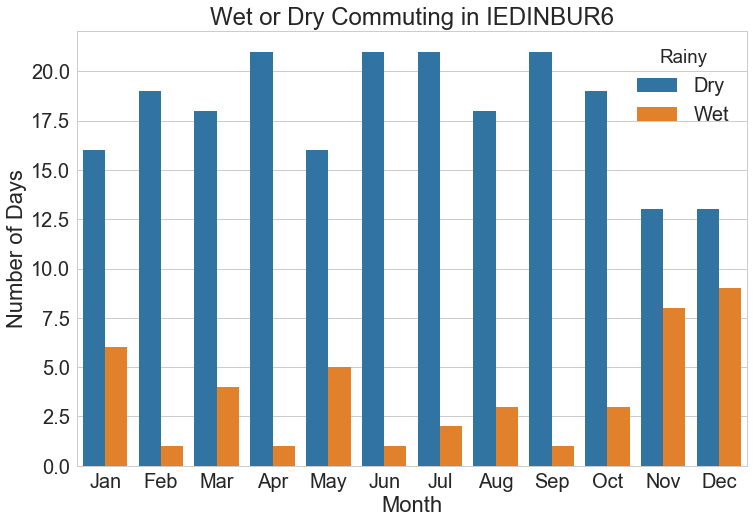

In [19]:
# Monthly plot of rainy days
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Days", hue="Rainy", data=monthly.sort_values(['month', 'Rainy']))
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.title("Wet or Dry Commuting in {}".format(station))

The heatmaps we are using would be generated using the “calmap” python library. We just create a Pandas series with a DateTimeIndex and the library takes care of the rest.

In [20]:
temp = rainy_days.copy().set_index(pd.DatetimeIndex(rainy_days['date']))
temp.head()

,date,rain,rain_amount,total_rain,get_wet_cycling,hours_raining
date,,,,,,
2015-01-01,2015-01-01,True,52.2,4.6,True,10.0
2015-01-02,2015-01-02,True,52.0,4.8,False,8.0
2015-01-03,2015-01-03,False,0.0,0.0,False,0.0
2015-01-04,2015-01-04,False,0.0,0.0,False,0.0
2015-01-05,2015-01-05,False,0.0,0.0,False,0.0


Text(0.5,1,'Total Rainfall Daily')

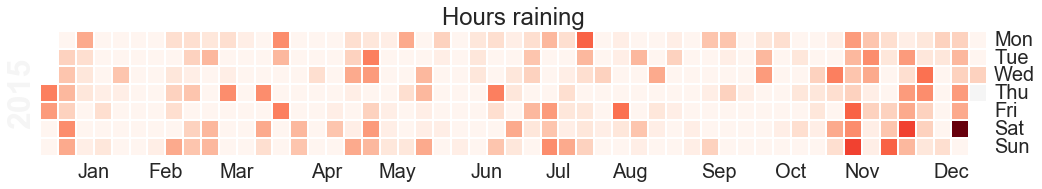

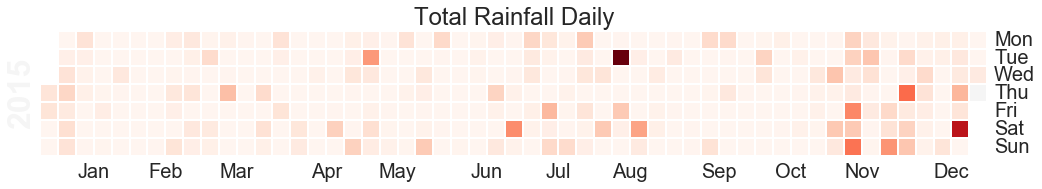

In [22]:
import calmap

temp = rainy_days.copy().set_index(pd.DatetimeIndex(rainy_days['date']))
#temp.set_index('date', inplace=True)
fig, ax = calmap.calendarplot(temp['hours_raining'], fig_kws={"figsize":(15,4)})
plt.title("Hours raining")
fig, ax = calmap.calendarplot(temp['total_rain'], fig_kws={"figsize":(15,4)})
plt.title("Total Rainfall Daily")

The Calmap package is very useful for generating heatmaps. Note that if you have highly outlying points of data, these will skew your color mapping considerably – I’d advise removing or reducing them for visualisation purposes.

Heatmap of total rainfall daily over 2015. Note that if you are looking at rainfall data like this, outlying values such as that in August in this example will skew the overall visualisation and reduce the colour-resolution of smaller values. Its best to normalise the data or reduce the outliers prior to plotting.

Pandas can be used for error checking and sense checking your results. For example:

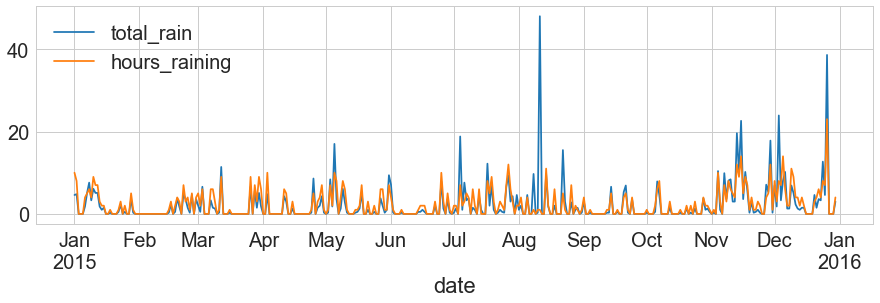

In [24]:
temp[['get_wet_cycling', 'total_rain', 'hours_raining']].plot(figsize=(15,4))

To compare every city in the dataset, summary stats for each city can calculated in advance and then the plot would be generated using the seaborn library. To achieve this as quickly as possible, let's wrap the entire data preparation and cleansing phase described above into a single function called “analyse data”, using this function on each city’s dataset, and extracting out the pieces of information needed for the plot.

In [25]:
def analyse_station(data_raw, station):
    """
    Function to analyse weather data for a period from one weather station.
    
    Args:
        data_raw (pd.DataFrame): Pandas Dataframe made from CSV downloaded from wunderground.com
        station (String): Name of station being analysed (for comments)
    
    Returns:
        dict: Dictionary with analysis in keys:
            data: Processed and cleansed data
            monthly: Monthly aggregated statistics on rainfall etc.
            wet_cycling: Data on working days and whether you get wet or not commuting
            rainy_days: Daily total rainfall for each day in dataset.
    """
    # Give the variables some friendlier names and convert types as necessary.
    data_raw['temp'] = data_raw['TemperatureC'].astype(float)
    data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
    data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
    data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
    data_raw['humidity'] = data_raw['Humidity'].astype(float)
    data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
    data_raw['wind'] = data_raw['WindSpeedKMH']
    
    # Extract out only the data we need.
    data = data_raw.loc[:, ['date', 'station', 'temp', 'rain', 'total_rain', 'humidity', 'wind']]
    data = data[(data['date'] >= datetime(2015,1,1)) & (data['date'] <= datetime(2015,12,31))]
    data.head()
    
    # There's an issue with some stations that record rainfall ~-2500 where data is missing.
    if (data['rain'] < -500).sum() > 10:
        print("There's more than 10 messed up days for {}".format(station))

    # remove the bad samples
    data = data[data['rain'] > -500]
    
    # Assign the "day" to every date entry
    data['day'] = data['date'].apply(lambda x: x.date())

    # Get the time, day, and hour of each timestamp in the dataset
    data['time_of_day'] = data['date'].apply(lambda x: x.time())
    data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
    data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)

    # Mark the month for each entry so we can look at monthly patterns
    data['month'] = data['date'].apply(lambda x: x.month)
    
    # Is each time stamp on a working day (Mon-Fri)
    data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)
    
    # Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
    data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
    data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))
    
    # If there's any rain at all, mark that!
    data['raining'] = data['rain'] > 0.0

    # You get wet cycling if its a working day, and its raining at the travel times!
    data['get_wet_cycling'] = (data['working_day']) & ((data['morning'] & data['rain']) |
                                                       (data['evening'] & data['rain']))
    
    # Looking at the working days only and create a daily data set of working days:
    wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
    wet_cycling = pd.DataFrame(wet_cycling).reset_index()
    
    # Group by month for display - monthly data set for plots.
    wet_cycling['month'] = wet_cycling['day'].apply(lambda x: x.month)
    monthly = wet_cycling.groupby('month')['get_wet_cycling'].value_counts().rename(columns={"get_wet_cycling":"Rainy"}, inplace=True)
    monthly = monthly.reset_index()
    monthly.rename(columns={"get_wet_cycling":"Rainy", 0:"Days"}, inplace=True)
    monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)    
    monthly['month_name'] = monthly['month'].apply(lambda x: calendar.month_abbr[x])
    
    # Get aggregate stats for each day in the dataset on rain in general - for heatmaps.
    rainy_days = data.groupby(['day']).agg({
                "rain": [("rain", lambda x: (x > 0.0).any()), ("rain_amount", "sum")],
                "total_rain": [("total_rain", "max")],
                "get_wet_cycling": [("get_wet_cycling", "any")]
            })
    
    # clean up the aggregated data to a more easily analysed set:
    rainy_days.reset_index(inplace=True) # remove the 'day' as the index
    rainy_days.rename(columns={"":"date"}, inplace=True) # The old index column didn't have a name - add "date" as name
    rainy_days.columns = rainy_days.columns.droplevel(level=0) # The aggregation left us with a multi-index
                                                               # Remove the top level of this index.
    rainy_days['rain'] = rainy_days['rain'].astype(bool)
    
    # Add the number of rainy hours per day this to the rainy_days dataset.
    temp = data.groupby(["day", "hour_of_day"])['raining'].any()
    temp = temp.groupby(level=[0]).sum().reset_index()
    temp.rename(columns={'raining': 'hours_raining'}, inplace=True)
    temp['day'] = temp['day'].apply(lambda x: pd.to_datetime(x).date())
    
    rainy_days = rainy_days.merge(temp, left_on='date', right_on='day', how='left')
    rainy_days.drop('day', axis=1, inplace=True)      # Change the "rain" column to True/False values
    
    print("In the year, there were {} rainy days of {} at {}".format(rainy_days['rain'].sum(), len(rainy_days), station))    
    print("It was wet while cycling {} working days of {} at {}".format(wet_cycling['get_wet_cycling'].sum(), 
                                                          len(wet_cycling),
                                                         station))
    print("You get wet cycling {} % of the time!!".format(round(wet_cycling['get_wet_cycling'].sum()*1.0*100/len(wet_cycling), 2)))
    
    return {"data":data, 'monthly':monthly, "wet_cycling":wet_cycling, 'rainy_days': rainy_days}

In [30]:
# Load up each of the stations into memory.
stations = [
    ("IAMSTERD55", "Amsterdam"),
    ("IBCNORTH17", "Vancouver"),
    ("IBELFAST4", "Belfast"),
    ("IBERLINB54", "Berlin"),
    ("ICOGALWA4", "Galway"),
    ("ICOMUNID56", "Madrid"),
    ("IDUBLIND35", "Dublin"),
    ("ILAZIORO71", "Rome"),
    ("ILEDEFRA6", "Paris"),
    ("ILONDONL28", "London"),
    ("IMUNSTER11", "Cork"),
    ("INEWSOUT455", "Sydney"),
    ("ISOPAULO61", "Sao Paulo"), 
    ("IWESTERN99", "Cape Town"),
    ("KCASANFR148", "San Francisco"),
    ("KNYBROOK40", "New York"),
    ("IRENFREW4", "Glasgow"),
    ("IENGLAND64", "Liverpool"),
    ('IEDINBUR6', 'Edinburgh')
]

In [32]:
data = []

for station in stations:
   weather = {}
   print("Loading data for station: {}".format(station[1]))
   weather['data'] = pd.read_csv("weather_station_hourly_data/{}_weather.csv".format(station[0]))
   weather['station'] = station[0]
   weather['name'] = station[1]
   data.append(weather)

Loading data for station: Amsterdam
Loading data for station: Vancouver
Loading data for station: Belfast
Loading data for station: Berlin
Loading data for station: Galway
Loading data for station: Madrid
Loading data for station: Dublin
Loading data for station: Rome
Loading data for station: Paris
Loading data for station: London
Loading data for station: Cork
Loading data for station: Sydney
Loading data for station: Sao Paulo
Loading data for station: Cape Town
Loading data for station: San Francisco
Loading data for station: New York
Loading data for station: Glasgow
Loading data for station: Liverpool
Loading data for station: Edinburgh


In [33]:
for ii in range(len(data)):
    print("Processing data for {}".format(data[ii]['name']))
    data[ii]['result'] = analyse_station(data[ii]['data'], data[ii]['station'])
 
# Now extract the number of wet days, the number of wet cycling days, and the number of wet commutes for a single chart.
output = []
for ii in range(len(data)):
    temp = {
            "total_wet_days": data[ii]['result']['rainy_days']['rain'].sum(),
            "wet_commutes": data[ii]['result']['wet_cycling']['get_wet_cycling'].sum(),
            "commutes": len(data[ii]['result']['wet_cycling']),
            "city": data[ii]['name']
        }
    temp['percent_wet_commute'] = (temp['wet_commutes'] *1.0 / temp['commutes'])*100
    output.append(temp)
output = pd.DataFrame(output)

Processing data for Amsterdam
There's more than 10 messed up days for IAMSTERD55
In the year, there were 194 rainy days of 359 at IAMSTERD55
It was wet while cycling 58 working days of 257 at IAMSTERD55
You get wet cycling 22.57 % of the time!!
Processing data for Vancouver
In the year, there were 115 rainy days of 363 at IBCNORTH17
It was wet while cycling 25 working days of 259 at IBCNORTH17
You get wet cycling 9.65 % of the time!!
Processing data for Belfast
In the year, there were 235 rainy days of 364 at IBELFAST4
It was wet while cycling 93 working days of 260 at IBELFAST4
You get wet cycling 35.77 % of the time!!
Processing data for Berlin
There's more than 10 messed up days for IBERLINB54
In the year, there were 123 rainy days of 351 at IBERLINB54
It was wet while cycling 25 working days of 251 at IBERLINB54
You get wet cycling 9.96 % of the time!!
Processing data for Galway
In the year, there were 266 rainy days of 358 at ICOGALWA4
It was wet while cycling 114 working days of 

In [29]:
output.head()

,city,commutes,percent_wet_commute,total_wet_days,wet_commutes
0,Amsterdam,257,22.568093,194,58
1,Vancouver,259,9.652510,115,25
2,Belfast,260,35.769231,235,93
3,Berlin,251,9.960159,123,25
4,Galway,256,44.531250,266,114


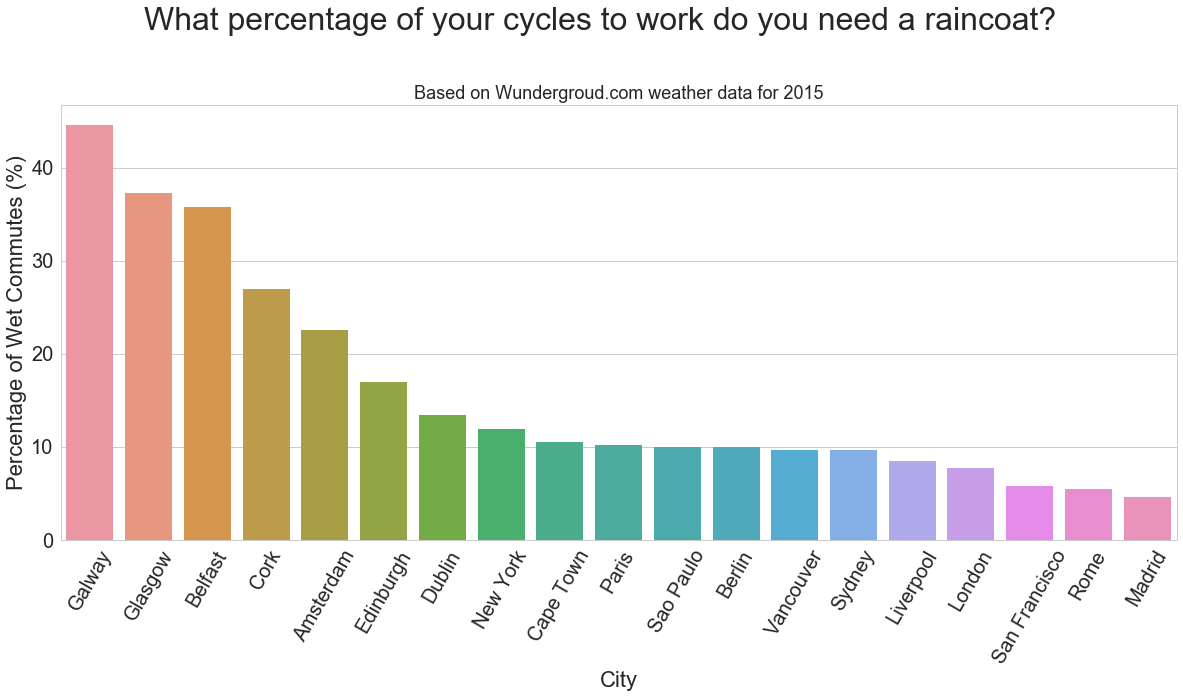

In [35]:
# Generate plot of percentage of wet commutes
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=2)
sns.barplot(x="city", y="percent_wet_commute", data=output.sort_values('percent_wet_commute', ascending=False))
plt.xlabel("City")
plt.ylabel("Percentage of Wet Commutes (%)")
plt.suptitle("What percentage of your cycles to work do you need a raincoat?", y=1.05, fontsize=32)
plt.title("Based on Wundergroud.com weather data for 2015", fontsize=18)
plt.xticks(rotation=60)
plt.savefig("weather_station_hourly_data/city_comparison_wet_commutes.png", bbox_inches='tight')

In [2]:

def getRainfallData(station, day, month, year):
    """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    # remove the excess <br> from the text data
    data = data.replace('<br>', '')
    # Convert to pandas dataframe (fails if issues with weather station)
    try:
        dataframe = pd.read_csv(io.StringIO(data), index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year,station))
        return None
    return dataframe
    
# Generate a list of all of the dates we want data for
start_date = "2015-01-01"
end_date = "2015-12-31"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))

# Create a list of stations here to download data for
stations = ["IDUBLINF3", "IDUBLINF2", "ICARRAIG2", "IGALWAYR2", "IBELFAST4", "ILONDON59", "IILEDEFR28"]
# Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}

# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period status update messages
        if date.day % 10 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    # Finally combine all of the individual days and output to CSV for analysis.
    pd.concat(data[station]).to_csv("data/{}_weather.csv".format(station))


Working on IDUBLINF3


ConnectionError: HTTPConnectionPool(host='www.wunderground.com', port=80): Max retries exceeded with url: /weatherstation/WXDailyHistory.asp?ID=IDUBLINF3&day=1&month=1&year=2015&graphspan=day&format=1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000000706A31358>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))